<a href="https://colab.research.google.com/github/EmanuelAlogna/MRI-generation/blob/master/results/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython import display
import time
import math

print(tf.__version__)

from google.colab import drive
drive.mount('/content/drive')

TensorFlow 2.x selected.
2.1.0-rc1
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Loading the validation and test sets

In [0]:
def get_feature_description(modalities):                                                   
                                                                                           
    feature_description =lambda mod : {                                                    
                            mod+'_mri': tf.io.FixedLenFeature([], tf.string),              
                            mod+'_path': tf.io.FixedLenFeature([], tf.string),             
                                                                                           
                            mod+'_mri_min': tf.io.FixedLenFeature([], tf.float32),         
                            mod+'_mri_min_src': tf.io.FixedLenFeature([], tf.float32),     
                            mod+'_mri_max': tf.io.FixedLenFeature([], tf.float32),         
                            mod+'_mri_max_src': tf.io.FixedLenFeature([], tf.float32),     
                                                                                           
                            mod+'_mri_lperc': tf.io.FixedLenFeature([], tf.float32),       
                            mod+'_mri_hperc': tf.io.FixedLenFeature([], tf.float32),       
                            mod+'_mri_hperc_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_mri_lperc_src': tf.io.FixedLenFeature([], tf.float32),   
                                                                                           
                            mod+'_x_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_y_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_z_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_z_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                            mod+'_x_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                            mod+'_y_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                                                                                           
                            mod+'_x_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                            mod+'_y_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                            mod+'_z_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                                                                                           
                            mod+'_z_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_x_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_y_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                                                                                           
                            mod+'_patient': tf.io.FixedLenFeature([], tf.string),          
                            mod+'_sample_number': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_patient_grade': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_location': tf.io.FixedLenFeature([], tf.string),         
                            mod+'_dataset_version': tf.io.FixedLenFeature([], tf.string),  
                            mod+'_dataset_name': tf.io.FixedLenFeature([], tf.string),     
                            mod+'_mri_type': tf.io.FixedLenFeature([], tf.string),         
                            mod+'_dataset_split': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_patient_mri_seq': tf.io.FixedLenFeature([], tf.string),  
                          }                                                                
    features = {}                                                                          
    for mod in modalities:
        features.update(feature_description(mod))
    return features

In [0]:
#BUFFER_SIZE = 400
BATCH_SIZE = 32

In [0]:
use_gzip_compression = True

def load_dataset(name, mri_type, center_crop=None, random_crop=None, filter=None, batch_size=BATCH_SIZE, cache=True, 
                 prefetch_buffer=1, shuffle_buffer=128, interleave=1, cast_to=tf.float32, clip_labels_to=0.0, 
                 take_only=None, shuffle=True, infinite=False, n_threads=os.cpu_count()):
    def parse_sample(sample_proto):
        parsed = tf.io.parse_single_example(sample_proto, get_feature_description(["OT"]+mri_type))
        # Decoding image arrays
        
        slice_shape = [parsed['OT_x_dimension'.format(mri_type[0])], parsed['OT_y_dimension'], 1]
        # Decoding the ground truth
        parsed['seg'] = tf.cast(tf.reshape(tf.io.decode_raw(parsed['OT_mri'], tf.float32), shape=slice_shape), dtype=cast_to)
        # Decode each channel and stack in a 3d volume
        stacked_mri = list()
        for mod in mri_type:
            stacked_mri.append(tf.cast(tf.reshape(tf.io.decode_raw(parsed['{}_mri'.format(mod)], tf.float32), shape=slice_shape), dtype=cast_to))
        parsed['mri'] = tf.concat(stacked_mri, axis=-1)
        # Clipping the labels if requested
        parsed['seg'] = tf.clip_by_value(parsed['seg'], 0.0, clip_labels_to) if clip_labels_to else parsed['seg']
        
        # Cropping
        if random_crop or center_crop:
            # Stacking the mri and the label to align the crop shape
            mri_seg = tf.concat([parsed['mri'], parsed['seg']], axis=-1)
            if random_crop:
                random_crop[-1] = mri_seg.shape[-1] 
                cropped = tf.image.random_crop(mri_seg, size=random_crop)
            else:
                cropped = tf.image.resize_with_crop_or_pad(mri_seg,center_crop[0],center_crop[1])
            # Splitting back
            parsed['mri'] = cropped[:,:,:len(mri_type)]
            parsed['seg'] = cropped[:,:,len(mri_type):]
        
        return parsed
    
    path = './drive/My Drive/MRI-generation/{}.tfrecords'.format(name)
    dataset = tf.data.TFRecordDataset(path, compression_type='GZIP' if use_gzip_compression else "")
    dataset = dataset.filter(filter) if filter is not None else dataset
    dataset = dataset.take(take_only) if take_only is not None else dataset

    # You should generally cache after loading and preprocessing the data, 
    # but before shuffling, repeating, batching and prefetching”
    dataset = dataset.cache() if cache else dataset
    if shuffle and infinite:
        dataset = dataset.apply(tf.data.experimental.shuffle_and_repeat(shuffle_buffer))
    else:
        dataset = dataset.shuffle(shuffle_buffer, reshuffle_each_iteration=True) if shuffle else dataset
        dataset = dataset.repeat() if infinite else dataset
    dataset = dataset.map(parse_sample, num_parallel_calls=None)
    dataset = dataset.batch(batch_size) if batch_size > 0 else dataset

    if interleave > 1:
        dataset = dataset.interleave(lambda x: tf.data.Dataset.from_tensors(x).repeat(interleave), cycle_length=n_threads, block_length=interleave, num_parallel_calls=n_threads)
  
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [0]:
# Loading only validation and testing (no need to load the training)

def load_datasets():
    validation = load_dataset('brats2015_validation_crop_mri', ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair'], shuffle=False)
    training = load_dataset('brats2015_training_crop_mri', ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair'], shuffle=True)
    testing = load_dataset('brats2015_testing_crop_mri', ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair'], shuffle=True)
    return training, validation , testing

In [0]:
training, validation, testing = load_datasets() # I'll use this in case I get stuck with the cache.

modalities = ['MR_T1_mri', 'MR_T2_mri', 'MR_T1c_mri', 'MR_Flair_mri', 'OT_mri']

In [0]:
# PROCESSING IMAGES IN THE BATCH
def process_batch(batch):   # takes in input a raw_record[mod].numpy()
    batch = tf.io.decode_raw(batch, tf.float32)
    batch = tf.reshape(batch, (BATCH_SIZE, 180, 180))
    paddings = tf.constant([[0, 0], [38, 38], [38, 38]])
    batch = tf.pad(batch, paddings, "CONSTANT")
    batch = tf.expand_dims(batch, axis=3)
    return batch
    
# final shape will be (bs, 256, 256, 1): now the batch is ready to be fed to the GAN

In [0]:
# this function preprocesses the input image and the ground truth from a raw_record
# images in the return are then ready to be fed into the GAN
def take_images_from_raw(raw_record, ot=False):

    t1, t2, t1c, tflair = raw_record[modalities[0]], raw_record[modalities[1]], raw_record[modalities[2]], raw_record[modalities[3]]
    t1 = process_batch(t1)
    t2 = process_batch(t2)
    t1c = process_batch(t1c)
    tflair = process_batch(tflair)
    if ot:      # if ot is true, I'll retrieve also the segmentation from the raw_record
        segmentation = process_batch(raw_record[modalities[4]])
        return t1, t2, t1c, tflair, segmentation
    return t1, t2, t1c, tflair

## Load some useful functions




In [0]:
def resize_with_crop(*args): # possibile arguments: input, gt, prediction and maybe the segmentation

    image0 = tf.image.resize_with_crop_or_pad(args[0], 155, 194)
    image1 = tf.image.resize_with_crop_or_pad(args[1], 155, 194)
    image2 = tf.image.resize_with_crop_or_pad(args[2], 155, 194)
    image3 = tf.image.resize_with_crop_or_pad(args[3], 155, 194)
    if len(args) == 5:      # crop also the segmentation, if is given as additional argument
        image4 = tf.image.resize_with_crop_or_pad(args[4], 155, 194)
        return image0, image1, image2, image3, image4
    if len(args) == 6:      # crop also the segmentation, if is given as additional argument
        image4 = tf.image.resize_with_crop_or_pad(args[4], 155, 194)
        image5 = tf.image.resize_with_crop_or_pad(args[5], 155, 194)
        return image0, image1, image2, image3, image4, image5
    return image0, image1, image2, image3

In [0]:
 # this method was tested to work with 5 and 32 images. Plotting 2, 3 or 4 types per time.

def plot_images(*args, images_to_print=5): 
    if images_to_print == 5: x = 15
    elif images_to_print == 6: x = 20
    elif images_to_print == 32: x = 90
    if len(args) == 3:
        display_list = [args[0], args[1], args[2]]     # input, gt and prediction
        title = ['Input Image', 'Ground Truth', 'Predicted Image']
        figsize = (x , 9)
    elif len(args) == 2:
        display_list = [args[0], args[1]]     # input and gt
        title = ['Input Image', 'Ground Truth']
        figsize = (x , 7)
    elif len(args) == 4:
        display_list = [args[0], args[1], args[2], args[3]]     # gt, prediction, gt_masked, prediction_masked
        title = ['Ground Truth', 'Prediction', 'GT in tumor area', 'Pred in tumor area']
        figsize = (x , 12)
    plt.figure(1 , figsize)
    n = 0
    for i in range(len(args)):
        for j in range(images_to_print):    # batch size is different from 10, but let's show just 10 images.
            n += 1
            plt.subplot(len(args)+1, images_to_print, n).title.set_text(title[i])
            plt.imshow(tf.squeeze(display_list[i][j]), cmap='bone')
            plt.axis('off')
    plt.show()
    print()


In [0]:
# MASK THE SEGMENTATION with the prediciton and the ground_truth and then compute the metrics (even if there is the black pixels
# it should give me an idea about how much is going the generation of the tumor during the generation. of course the score
# will be influeced (biased) by all the black pixels.)

def retrieve_tumor_area(ground_truth, prediction, segmentation):
    ground_truth_np = ground_truth.numpy()
    segmentation_np = segmentation.numpy()
    prediction_np = prediction.numpy()

    # I want to remove all the pixels not relevant wrt the tumor area. 
    idx = (segmentation_np==0)      
    ground_truth_np[idx] = segmentation_np[idx]
    prediction_np[idx] = segmentation_np[idx]

    return ground_truth_np, prediction_np      # Now the images are ready to be evaluated

In [0]:
for raw_record in testing.take(1):
    t1, t2, t1c, tflair, ot = take_images_from_raw(raw_record, ot=True)

    #t1_cr, t2_cr, t1c_cr, tflair_cr, t2_generated_cr = resize_with_crop(t1, t2, t1c, tflair, t2_generated)
    #plot_images(t1_cr, t1c_cr, tflair_cr, t2_cr, t2_generated_cr )


In [13]:
ot.shape

TensorShape([32, 256, 256, 1])

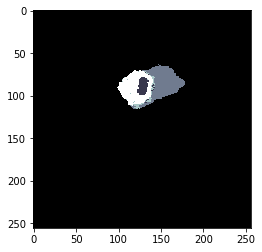

In [14]:
plt.imshow(tf.squeeze(ot[0]), cmap='bone')

In [0]:
# this method was tested to work with 5 and 32 images. Plotting 2, 3 or 4 types per time.

def plot_images_new(*args): 

    if len(args) == 5:
        display_list = [args[0], args[1], args[2], args[3], args[4]]   # input, gt, prediction, gt masked, pred masked
        title = ['T1', 'T1c', 'T1flair', 'T2 - ground Truth', 'T2 - Predicted Image']
        figsize = (14, 7)
    elif len(args) == 3:
        display_list = [args[0], args[1], args[2]]   # input, gt and prediction
        title = ['Input Image', 'Ground Truth', 'Predicted Image']
        figsize = (8, 4)
    elif len(args) == 7:
        display_list = [args[0], args[1], args[2], args[3], args[4], args[5], args[6]]   # input, gt and prediction
        title = ['T1', 'T1c', 'T1flair', 'T2 - ground Truth', 'T2 - Predicted Image', 'GT Tumor', 'Pred Tumor']
        figsize = (17, 4)
    
    plt.figure(1 , figsize)
    n = 0
    for i in range(len(args)):    # batch size is different from 10, but let's show just 10 images.
        n += 1
        plt.subplot(1, len(args), n).title.set_text(title[i])
        plt.imshow(tf.squeeze(display_list[i][0]), cmap='bone')
        plt.axis('off')
    plt.show()

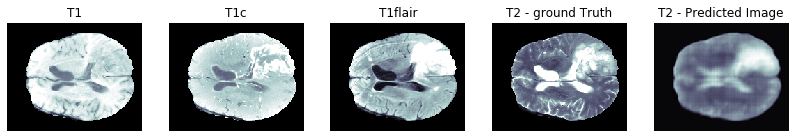

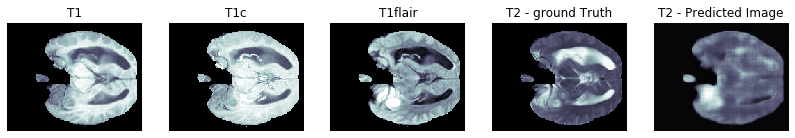

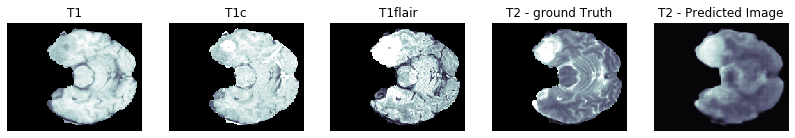

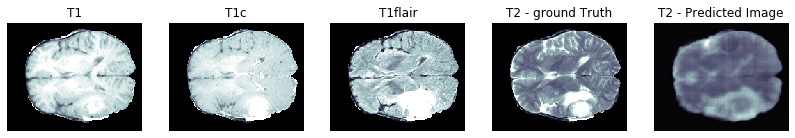

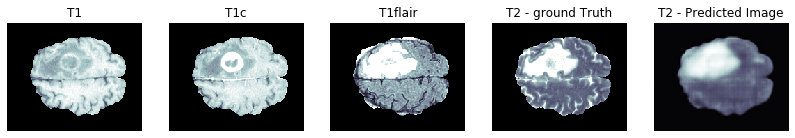

In [40]:
evaluate_tumor_area = False
for idx, raw_record in validation.enumerate():
    t1, t2, t1c, tflair, segmentation = take_images_from_raw(raw_record, ot=True)
    # preparing the input to the generator
    t2_original = t2
    # INPUT IMPUTATION
    gt_imputed = tf.zeros((32, 256, 256, 1), dtype=tf.dtypes.float32)
    input_tensor = tf.concat([t1, gt_imputed, t1c, tflair], 3)

    # generate the prediction            
    prediction = gen(input_tensor, training=False)

    # extracting the t2_prediction from the predictions (I'm only interested in T2)
    t2_generated = prediction[:, :, :, 1]     # this will be used to compute the loss and then fed to the discriminator
    t2_generated = tf.expand_dims(t2_generated, axis=3)     # cause in plot_images it will tf.squeeze

    # crop the images
    t1_cr, t1c_cr, tflair_cr, t2_original_cr, t2_generated_cr, segmentation_cr = resize_with_crop(t1, t1c, tflair, t2_original, t2_generated, segmentation)
    if evaluate_tumor_area:
        ground_truth_masked, prediction_masked = retrieve_tumor_area(t2_original_cr, t2_generated_cr, segmentation_cr)
    if (idx == 2 or idx == 25 or idx == 45 or idx == 50 or idx == 83) and evaluate_tumor_area:
        plot_images_new(t1_cr, t1c_cr, tflair_cr, t2_original_cr, t2_generated_cr, ground_truth_masked, prediction_masked)
    elif idx == 2 or idx == 25 or idx == 45 or idx == 50 or idx == 83:
        plot_images_new(t1_cr, t1c_cr, tflair_cr, t2_original_cr, t2_generated_cr)

In [0]:
def evaluate_GAN(model, dataset, set_type, evaluate_tumor_area=False):
    num_batches = 0                 # CAREFUL when batch_size is modified!!!
    if set_type == 'test':
        num_batches = 112           # in the test set, with batch 32, there are 112 elements.
    elif set_type == 'validation':
        num_batches = 108
    elif set_type == 'train':
        num_batches = 876
    container_psnr = tf.TensorArray(tf.float32, size=num_batches)     
    container_mse = tf.TensorArray(tf.float32, size=num_batches)
    container_ssim = tf.TensorArray(tf.float32, size=num_batches)
    
    if evaluate_tumor_area:
        container_psnr_tumor = tf.TensorArray(tf.float32, size=num_batches)     
        container_mse_tumor = tf.TensorArray(tf.float32, size=num_batches)
        container_ssim_tumor = tf.TensorArray(tf.float32, size=num_batches)
    
    for idx, raw_record in dataset.enumerate():
        t1, t2, t1c, tflair, segmentation = take_images_from_raw(raw_record, ot=True)
        # preparing the input to the generator
        t2_original = t2
        # INPUT IMPUTATION
        gt_imputed = tf.zeros((32, 256, 256, 1), dtype=tf.dtypes.float32)
        input_tensor = tf.concat([t1, gt_imputed, t1c, tflair], 3)

        # generate the prediction            
        prediction = model(input_tensor, training=False)

        # extracting the t2_prediction from the predictions (I'm only interested in T2)
        t2_generated = prediction[:, :, :, 1]     # this will be used to compute the loss and then fed to the discriminator
        t2_generated = tf.expand_dims(t2_generated, axis=3)     # cause in plot_images it will tf.squeeze

        # crop the images
        t1_cr, t1c_cr, tflair_cr, t2_original_cr, t2_generated_cr, segmentation_cr = resize_with_crop(t1, t1c, tflair, t2_original, t2_generated, segmentation)
        if evaluate_tumor_area:
            ground_truth_masked, prediction_masked = retrieve_tumor_area(t2_original_cr, t2_generated_cr, segmentation_cr)
        if (idx == 2 or idx == 25 or idx == 45 or idx == 50 or idx == 83) and evaluate_tumor_area:
            plot_images_new(t1_cr, t1c_cr, tflair_cr, t2_original_cr, t2_generated_cr, ground_truth_masked, prediction_masked)
        elif idx == 2 or idx == 25 or idx == 45 or idx == 50 or idx == 83:
            plot_images_new(t1_cr, t1c_cr, tflair_cr, t2_original_cr, t2_generated_cr)
        
        # normalize the prediction and the ground_truth
        prediction_normalized_cr = mean_normalize(t2_generated_cr)
        ground_truth_normalized_cr = mean_normalize(t2_original_cr)

        # compute the metrics of similarity
        mean, std, psnr = compute_psnr(ground_truth_normalized_cr, prediction_normalized_cr)
        container_psnr = container_psnr.write(idx, psnr)
        mean, std, mse = compute_mse(ground_truth_normalized_cr, prediction_normalized_cr)
        container_mse = container_mse.write(idx, mse)
        mean, std, ssim = compute_ssim(ground_truth_normalized_cr, prediction_normalized_cr)
        container_ssim = container_ssim.write(idx, ssim)

        if evaluate_tumor_area:

            # discard black images from pred and gt
            prediction_masked_normalized = mean_normalize(prediction_masked)
            ground_truth_masked_normalized = mean_normalize(ground_truth_masked) 
            
            mean, std, psnr = compute_psnr(ground_truth_masked_normalized, prediction_masked_normalized)
            container_psnr_tumor = container_psnr_tumor.write(idx, psnr)
            mean, std, mse = compute_mse(ground_truth_masked_normalized, prediction_masked_normalized)
            container_mse_tumor = container_mse_tumor.write(idx, mse)
            mean, std, ssim = compute_ssim(ground_truth_masked_normalized, prediction_masked_normalized)
            container_ssim_tumor = container_ssim_tumor.write(idx, ssim)
    
    container_psnr = container_psnr.stack()
    container_mse = container_mse.stack()
    container_ssim = container_ssim.stack()
    mean_psnr = tf.reduce_mean(tf.boolean_mask((container_psnr), tf.math.is_finite(container_psnr)))
    std_psnr = tf.math.reduce_std(tf.boolean_mask((container_psnr), tf.math.is_finite(container_psnr)))
    mean_mse = tf.reduce_mean(tf.boolean_mask((container_mse), tf.math.is_finite(container_mse)))
    std_mse = tf.math.reduce_std(tf.boolean_mask((container_mse), tf.math.is_finite(container_mse)))
    mean_ssim = tf.reduce_mean(tf.boolean_mask((container_ssim), tf.math.is_finite(container_ssim)))
    std_ssim = tf.math.reduce_std(tf.boolean_mask((container_ssim), tf.math.is_finite(container_ssim)))
    
    print("PSNR on {} set: {} ± {}".format(set_type, (f'{mean_psnr:.4f}'), (f'{std_psnr:.4f}')))
    print("MSE on {} set: {} ± {}".format(set_type, (f'{mean_mse:.4f}'), (f'{std_mse:.4f}')))
    print("SSIM on {} set: {} ± {}".format(set_type, (f'{mean_ssim:.4f}'), (f'{std_ssim:.4f}')))

    if evaluate_tumor_area:
        container_psnr_tumor = container_psnr_tumor.stack()
        container_mse_tumor = container_mse_tumor.stack()
        container_ssim_tumor = container_ssim_tumor.stack()
        mean_psnr_tumor = tf.reduce_mean(tf.boolean_mask((container_psnr_tumor), tf.math.is_finite(container_psnr_tumor)))
        std_psnr_tumor = tf.math.reduce_std(tf.boolean_mask((container_psnr_tumor), tf.math.is_finite(container_psnr_tumor)))
        mean_mse_tumor = tf.reduce_mean(tf.boolean_mask((container_mse_tumor), tf.math.is_finite(container_mse_tumor)))
        std_mse_tumor = tf.math.reduce_std(tf.boolean_mask((container_mse_tumor), tf.math.is_finite(container_mse_tumor)))
        mean_ssim_tumor = tf.reduce_mean(tf.boolean_mask((container_ssim_tumor), tf.math.is_finite(container_ssim_tumor)))
        std_ssim_tumor = tf.math.reduce_std(tf.boolean_mask((container_ssim_tumor), tf.math.is_finite(container_ssim_tumor)))
        print()
        print("PSNR wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_psnr_tumor:.4f}'), (f'{std_psnr_tumor:.4f}')))
        print("MSE wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_mse_tumor:.4f}'), (f'{std_mse_tumor:.4f}')))
        print("SSIM wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_ssim_tumor:.4f}'), (f'{std_ssim_tumor:.4f}')))

## Min-max normalization

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/73032b45bffd5e5140483fbe1ed49bf174f1962d)

In [0]:
def min_max_rescale(x, xmin, xmax, a, b):
    return (a + (b-a)*(x-xmin)/(xmax-xmin))  
    # to rescale in the range [0, 1], 'a' must be 0 and 'b' = 1

In [0]:
@tf.function
def min_max_normalize(image):
    image_normalized = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        # rescaling each image in the batch
        max_value = tf.math.reduce_max(image[i])
        min_value = tf.math.reduce_min(image[i])
        x = min_max_rescale(image[i], min_value, max_value, 0, 1)
        image_normalized = image_normalized.write(i, x)
    image_normalized = image_normalized.stack()
    return image_normalized

## Mean normalization

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/5c591a0eeba163a12f69f937adbae5886d6273db)

In the paper they say: "Each patient scan is normalized by dividing each sequence by its mean intensity value. "
But the formula is taken from a lecture from Andrew Ng, where he defines the Mean normalization as in the formula above. (resource: https://www.youtube.com/watch?v=e1nTgoDI_m8)

See also: https://stats.stackexchange.com/questions/138046/normalizations-dividing-by-mean

In [0]:
def mean_rescale(x, xmin, xmax):
    mean = tf.reduce_mean(x)
    return ((x-mean)/(xmax-xmin)) 

In [0]:
@tf.function
def mean_normalize(image):
    image_normalized = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        # rescaling each image in the batch
        max_value = tf.math.reduce_max(image[i])
        min_value = tf.math.reduce_min(image[i])
        x = mean_rescale(image[i], min_value, max_value)
        image_normalized = image_normalized.write(i, x)
    image_normalized = image_normalized.stack()
    return image_normalized

## Discard black images from batch (put values to 'nan')

This normalization is just to test the metrics and see if there is a big difference in normalizing the prediction and the gt.
This method is used to normalize (and so put to 'nan') only the black images, while the other images of the batch are kept with the original values. This allows me to discard the black images in the computation of the metrics.

In [0]:
# this normalization is just to test the metrics and see if there is a big difference in normalizing the prediction and the gt.
# this method is used to normalize (and so put to 'nan') only the black images, while the other images of the batch are kept 
# with the original values. This allows me to discard the black images in the computation of the metrics.

def black_images_to_nan(image): 
    image_normalized = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        # rescaling each image in the batch
        max_value = tf.math.reduce_max(image[i])
        min_value = tf.math.reduce_min(image[i])

        # if the max = min most likely it's a black image (or an image without any important information)
        if tf.math.equal(max_value, min_value):        
            print("I found a black image! at index {}".format(i))
            x = mean_normalize(image[i], min_value, max_value)
            image_normalized = image_normalized.write(i, x)
        else:
            image_normalized = image_normalized.write(i, image[i])
    image_normalized = image_normalized.stack()
    return image_normalized

##Defining all the quantitative metrics (PSNR, SSIM and MSE)

In [0]:
def compute_psnr(image1, image2):
    # Compute PSNR over tf.float32 Tensors.
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    psnr = tf.image.psnr(im1, im2, max_val=1.0)
    mean = tf.reduce_mean(tf.boolean_mask((psnr), tf.math.is_finite(psnr)))
    std = tf.math.reduce_std(tf.boolean_mask((psnr), tf.math.is_finite(psnr)))
    # In the computation of mean and std, I'm ignoring the 'nan' and 'inf' values
    # Why 'nan' values? 'nan' happens when there is an image with max_value and min_value = 0.0 so a black image
    # the PSNR would be inf (image is totally similar to the ground truth)
    # be rescaling the image, the max_value and min_value would become nan and so the PSNR

    # It ignores also the 'inf' values, in the case I don't want to normalize
    
    return mean, std, psnr

In [0]:
def compute_ssim(image1, image2):
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    ssim = tf.image.ssim(im1, im2, max_val=1)
    mean = tf.reduce_mean(tf.boolean_mask((ssim), tf.math.is_finite(ssim)))
    std = tf.math.reduce_std(tf.boolean_mask((ssim), tf.math.is_finite(ssim)))
    return mean, std, ssim

In [0]:
# I want to compute, first thing, the MSE between ground truth and generated one. The tf.function gives me a Tensor 32x256x256:
# MSE is computed PIXEL per PIXEL, so per each of the 32 matrix 256x256, I average (1) the values of the 256x256 pixels obtaining
# an array of 32 elements, containing the MSEs of each image belonging to the batch. Then I can average (2) these 32 to have 
# I should not average the whole 32x256x256 in one step. The result would have same mean but slightly different std.
# I want first to obtain the MSE of each image... then I average across the batch only to have smth more accurate.

def compute_mse(image1, image2):       # mean squared error
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    mse = tf.metrics.mean_squared_error(im1,im2)
    # In this way is possible to do Variable item-assignment with tensors 
    mse_per_image = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        x = tf.reduce_mean(tf.boolean_mask((mse[i]), tf.math.is_finite(mse[i]))) 
        mse_per_image = mse_per_image.write(i, x)
    mse_per_image = mse_per_image.stack()
    mean = tf.reduce_mean(tf.boolean_mask((mse_per_image), tf.math.is_finite(mse_per_image)))
    std = tf.math.reduce_std(tf.boolean_mask((mse_per_image), tf.math.is_finite(mse_per_image)))
    return mean, std, mse_per_image

## Load the model

I'll first load the model that in format 'h5'. Then test this model.

After this, I'll recover the generator, discriminator and optimizer states and test it. 
They should lead to the same results in the test set

In [0]:
# Let's load the models that I saved

# Recreate the exact same model, including its weights and the optimizer
gen = tf.keras.models.load_model('drive/My Drive/MRI-generation/gen_t2_17&batch_MI-GAN.h5', compile=False)
# with compile = False, the warning it goes away. I don't want to fit the model, just to test it


## Evaluate performances of the model (using segmentation to evaluate the quality of the tumor generation)


I want to compute the metrics ONLY for the slices that present a segmentation, in order to understand how well that tumor was generated 

So I'll ignore the slices totally black. 

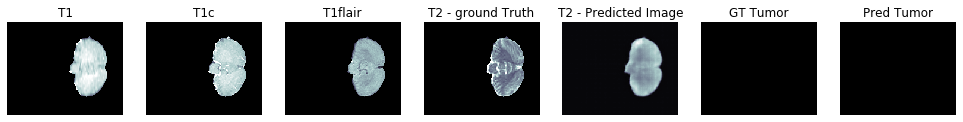

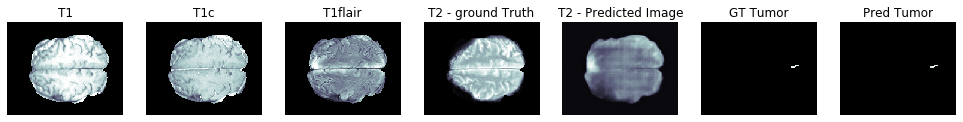

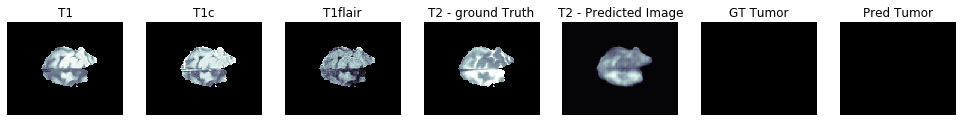

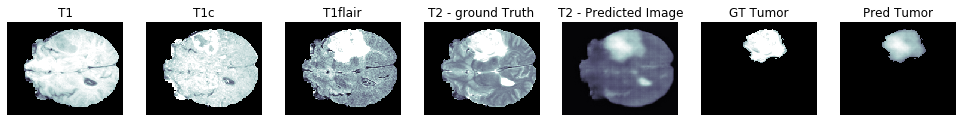

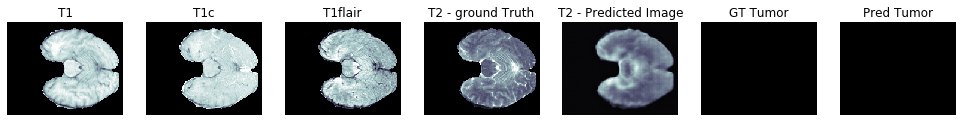

PSNR on test set: 19.0013 ± 3.0214
MSE on test set: 0.0151 ± 0.0080
SSIM on test set: 0.6748 ± 0.1354

PSNR wrt tumor area on test set: 31.4502 ± 13.2238
MSE wrt tumor area on test set: 0.0023 ± 0.0029
SSIM wrt tumor area on test set: 0.9595 ± 0.0373


In [54]:
# Let's check the scores of this model.

evaluate_GAN(gen, testing, 'test', evaluate_tumor_area=True)

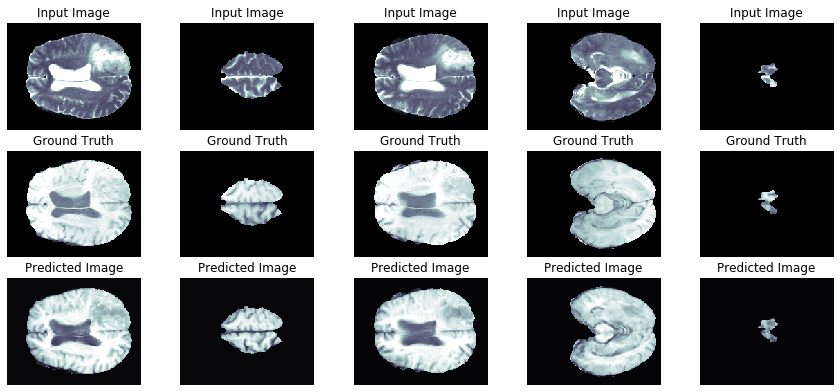


PSNR on validation set: 23.4471 ± 3.6357
MSE on validation set: 0.0058 ± 0.0039
SSIM on validation set: 0.8146 ± 0.0965

PSNR wrt tumor area on validation set: 33.6819 ± 10.7380
MSE wrt tumor area on validation set: 0.0012 ± 0.0014
SSIM wrt tumor area on validation set: 0.9674 ± 0.0296


In [0]:
# Let's check the scores of this model.

evaluate_GAN(gen, validation, 'validation', evaluate_tumor_area=True)

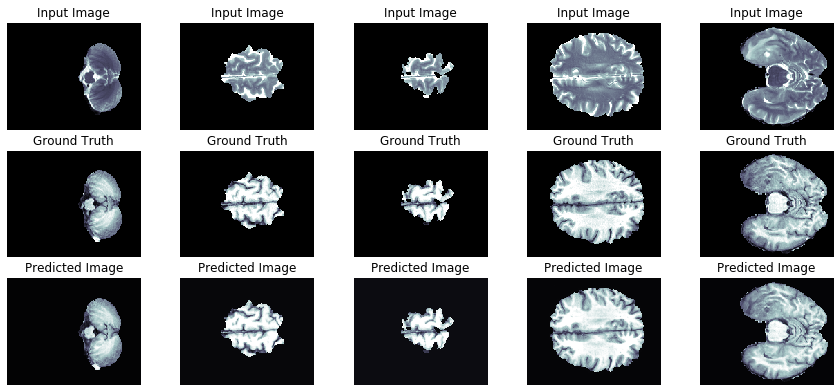


PSNR on train set: 27.2013 ± 3.5700
MSE on train set: 0.0027 ± 0.0038
SSIM on train set: 0.8774 ± 0.0882

PSNR wrt tumor area on train set: 39.2930 ± 11.0227
MSE wrt tumor area on train set: 0.0003 ± 0.0004
SSIM wrt tumor area on train set: 0.9851 ± 0.0152


In [0]:
# Let's check the scores of this model.

evaluate_GAN(gen, training, 'train', evaluate_tumor_area=True)

In [0]:


for raw_record in testing.take(1):
    inp, ground_truth, segmentation = take_images_from_raw(raw_record, True)
    prediction = gen(inp, training=False)
    inp, ground_truth, prediction = resize_with_crop(inp, ground_truth, prediction)
    plot_images(inp, ground_truth, prediction)
    

"\nevaluate_GAN(gen, testing, 'test', evaluate_tumor_area=True)\n\n\nfor raw_record in testing.take(1):\n    inp, ground_truth, segmentation = take_images_from_raw(raw_record, True)\n    prediction = gen(inp, training=False)\n    inp, ground_truth, prediction = resize_with_crop(inp, ground_truth, prediction)\n    plot_images(inp, ground_truth, prediction)\n    "